In [1]:
import numpy as np
import pystan as pst
import pysal as ps
import matplotlib.pyplot as plt
import seaborn.apionly as sns
import pandas as pd
%matplotlib inline

In [2]:
df = ps.pdio.read_files(ps.examples.get_path('south.shp')).query('STATE_NAME != "District of Columbia"')

In [3]:
df.index = np.arange(len(df), dtype=int)

In [4]:
df.head()

,FIPSNO,NAME,STATE_NAME,STATE_FIPS,CNTY_FIPS,FIPS,STFIPS,COFIPS,SOUTH,HR60,...,BLK90,GI59,GI69,GI79,GI89,FH60,FH70,FH80,FH90,geometry
0,54029,Hancock,West Virginia,54,029,54029,54,29,1,1.682864,...,2.557262,0.223645,0.295377,0.332251,0.363934,9.981297,7.8,9.785797,12.604552,<pysal.cg.shapes.Polygon object at 0x7ff443166...
1,54009,Brooke,West Virginia,54,009,54009,54,9,1,4.607233,...,0.748370,0.220407,0.318453,0.314165,0.350569,10.929337,8.0,10.214990,11.242293,<pysal.cg.shapes.Polygon object at 0x7ff443166...
2,54069,Ohio,West Virginia,54,069,54069,54,69,1,0.974132,...,3.310334,0.272398,0.358454,0.376963,0.390534,15.621643,12.9,14.716681,17.574021,<pysal.cg.shapes.Polygon object at 0x7ff443166...
3,54051,Marshall,West Virginia,54,051,54051,54,51,1,0.876248,...,0.546097,0.227647,0.319580,0.320953,0.377346,11.962834,8.8,8.803253,13.564159,<pysal.cg.shapes.Polygon object at 0x7ff443166...
4,10003,New Castle,Delaware,10,003,10003,10,3,1,4.228385,...,16.480294,0.256106,0.329678,0.365830,0.332703,12.035714,10.7,15.169480,16.380903,<pysal.cg.shapes.Polygon object at 0x7ff443166...


In [5]:
df.geometry.isnull().any()

False

In [6]:
W = ps.weights.Queen.from_dataframe(df)

In [121]:
def adjacencylist_from_W(W):
    """
    compute an adjacency list from a weights matrix
    """
    return pd.DataFrame(((idx, n,w) for idx,neighb in W for n,w in neighb.items()),
                         columns = ('focal', 'neighbor', 'weight'))

def W_from_adjacencylist(alist, focal_col='focal', neighbor_col='neighbor', weight_col='weight'):
    """
    Construct a W from an adjacency list
    """
    grouper = alist.groupby('focal')
    neighbors = grouper['neighbor'].apply(list)
    weights = grouper['weight'].apply(list)
    return ps.W(neighbors=neighbors.to_dict(), weights=weights.to_dict())

def adjlist_apply(vec, W=None, alist=None, func=np.subtract, skip_verify=False):
    """
    apply a function to an adajcency list, getting an adjacency list and result.
    """
    W,alist = _get_W_and_alist(W, alist, skip_verify=skip_verify)
    vec = np.asarray(vec).flatten()
    table = pd.DataFrame(np.vstack((W.id_order, vec)).T, columns=('id', 'att'))
    alist_atts = pd.merge(alist, table, how='left', 
                          left_on='focal', right_on='id')
    alist_atts = pd.merge(alist_atts, table, how='left', 
                          left_on='neighbor', right_on='id', suffixes=('_focal','_neighbor'))
    alist_atts.drop(['id_focal', 'id_neighbor'], axis=1, inplace=True)
    alist_atts[func.__name__] = alist_atts[['att_focal', 'att_neighbor']].apply(lambda x: func(x.att_focal, 
                                                                                               x.att_neighbor), axis=1)
    return alist_atts

def _get_W_and_alist(W, alist, skip_verify=False):
    """
    Either:
    1. compute a W from an alist
    2. adjacencylist from a W
    3. raise ValueError if neither are provided,
    4. raise AssertionError if both W and adjlist are provided and don't match.
    If this completes successfully, the W/adjlist will both be returned and are checked for equality.
    """
    if (alist is None) and (W is not None):
        alist = adjacencylist_from_W(W)
    elif (W is None) and (alist is not None):
        W = W_from_adjacencylist(alist)
    elif (W is None) and (alist is None):
        raise ValueError('Either W or Adjacency List must be provided')
    elif (W is not None) and (alist is not None) and (not skip_verify):
        np.testing.assert_allclose(W.sparse.toarray(), W_from_adjacencylist(alist).sparse.toarray())
    return W, alist

def adjlist_map(data, funcs=(np.subtract,), W=None, alist=None):
    if isinstance(data, pd.DataFrame):
        names = data.columns
        data = data.values
    else:
        names = [str(i) for i in range(data.shape[1])]
    assert data.shape[0] == W.n, "shape of data does not match shape of adjacency"
    if callable(funcs):
        funcs = (funcs,)
    if len(funcs) == 1:
        funcs = [funcs[0] for _ in range(data.shape[1])]
    assert data.shape[1] == len(funcs), "shape of data does not match the number of functions provided"
    W, alist = _get_W_and_alist(W,alist)
    fnames = set([f.__name__ for f in funcs])
    for i, (column, function) in enumerate(zip(data.T, funcs)):
        alist = adjlist_apply(vec=column, W=W, alist=alist, skip_verify=True)
        alist.drop(['att_focal', 'att_neighbor'], axis=1, inplace=True)
        alist = alist.rename(columns={function.__name__ :'_'.join((function.__name__, names[i]))})
        fnames.update((function.__name__,))
    return alist
def filter_adjlist(adjlist):
    """
    retain only one adjacency entry if there is a symmetric link
    """
    directed = set(map(tuple, adjlist[['focal', 'neighbor']].values))
    undirected = set()
    for tupe in directed:
        #print(tupe)
        if (tupe in undirected):
            to_drop = adjlist.query('focal == {} and neighbor == {}'
                                    .format(*tupe))
        elif (tuple(reversed(tupe)) in undirected):
            to_drop = adjlist.query('focal == {} and neighbor == {}'
                                    .format(*tuple(reversed(tupe))))
        else:
            undirected.update((tupe,))
            undirected.update((tuple(reversed(tupe),)))
            continue
        adjlist.drop(to_drop.index, inplace=True)
    return adjlist, 

In [123]:
test = adjlist_apply(df.HR90, W, func = np.subtract)

In [129]:
test2 = adjlist_map(df[['HR90', 'HR80', 'HR70']], W=W)

To womble, fit a model on this set of differences & find outliers to that regression. 

In [86]:
data = adjlist_map(df[['HR90', 'GI89', 'FH90', 'FH80']], W=W)

In [87]:
data = filter_adjlist(data)

In [88]:
data.shape

(4043, 7)

In [89]:
W.nonzero

8086

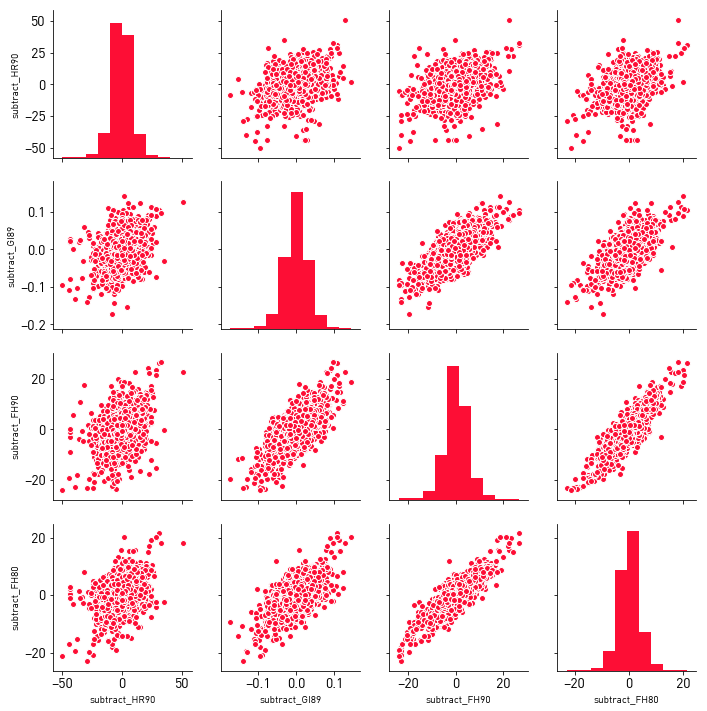

In [90]:
sns.pairplot(data.filter(like='subtract'))

In [91]:
import pystan as pst

In [92]:
data = pd.merge(data, df[['STATE_NAME']], left_on='focal', right_index=True, how='left')

In [93]:
dummies = pd.get_dummies(data.STATE_NAME).values

In [94]:
MODEL = """
data {
    int N;
    int P;
    int J;
    
    matrix[N,J] Delta;
    matrix[N,P] X;
    vector[N] Y;
}
parameters {
    
    vector[P] substantives;
    
    real mean_region;
    real<lower=0> std_region;
    vector[J] regions;
    
    real<lower=0> std;
}

model {
    mean_region ~ normal(0,100);
    std_region ~ cauchy(0,5);
    substantives ~ normal(0,10);
    regions ~ normal(mean_region, std_region);
    
    Y ~ normal(X * substantives + Delta * regions, std);
}
generated quantities{
    vector[N] ytil;
    for (i in 1:N){
        ytil[i] = normal_rng(X[i] * substantives + Delta[i] * regions, std);
    
    }
}
"""

In [95]:
X = data.filter(like='subtract').drop('subtract_FH90', axis=1).values
N,P = X.shape
Y = data[['subtract_FH90']].values
J = dummies.shape[1]
Delta = dummies.astype(int)

In [96]:
result = pst.stan(model_code=MODEL, data=dict(N=N,P=P, Y=Y.flatten(), J=J, Delta=Delta, X=X
    ))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_013de3d91507d41100e620d54a24c60e NOW.


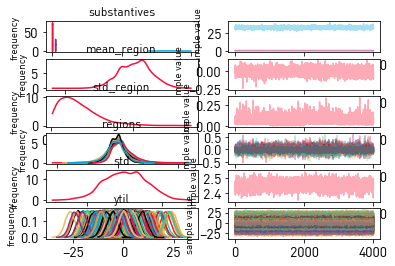

In [97]:
result.traceplot()
plt.show()

In [98]:
result

Inference for Stan model: anon_model_013de3d91507d41100e620d54a24c60e.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                  mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
substantives[0]   0.03  2.4e-4 5.2e-3   0.02   0.03   0.03   0.04   0.04    454   1.01
substantives[1]  33.33    0.08   1.49  30.41  32.31  33.35   34.4  36.05    338   1.01
substantives[2]   0.92  9.5e-4   0.01   0.89   0.91   0.92   0.93   0.94    176   1.02
mean_region    -3.8e-3  3.0e-3   0.05  -0.09  -0.04-2.4e-3   0.03   0.08    231   1.02
std_region        0.07  4.7e-3   0.05 6.3e-3   0.03   0.06   0.09   0.18     97   1.04
regions[0]       -0.02  2.5e-3   0.07  -0.19  -0.06  -0.02   0.03   0.11    882    1.0
regions[1]      9.3e-3  3.8e-3   0.08  -0.13  -0.04 6.8e-3   0.05   0.18    414   1.01
regions[2]     -3.0e-3  2.7e-3   0.09  -0.19  -0.05-3.4e-3   0.04   0.19   1148   1.01
regions[3]       -0.03  2.5e

In [100]:
ytil = result.extract('ytil')['ytil']
beta = result.extract('substantives')['substantives']
beta_est = beta[-500,:,None].mean(axis=1)
regionals = result.extract('regions')['regions']
regionals_est = regionals[-500,:,None].mean(axis=1)
yhat = X.dot(beta_est) + Delta.dot(regionals_est)

Let's look at the predicted vs. the observed:

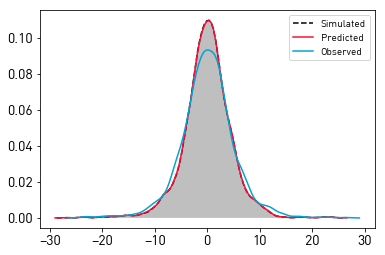

In [101]:
sns.kdeplot(ytil[-500:,:,None].mean(axis=0).flatten(),
            label='Simulated', linestyle='--', color='k', shade=True)
sns.kdeplot(yhat.flatten(), label='Predicted')
sns.kdeplot(Y.flatten(), label='Observed')

so, the simulations & predicted sets seem to be much more peaked than the observed stuff. predictions seem to be pretty under-eager. 

R-squared: 0.771155228166364


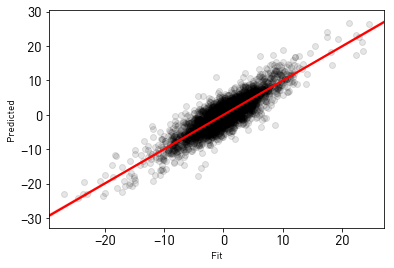

In [102]:
sns.regplot(yhat, Y.flatten(), 
            scatter_kws=dict(color='k', marker='.', alpha=.1),
            line_kws=dict(color='r'))
plt.xlabel('Fit')
plt.ylabel('Predicted')
from sklearn import metrics
print('R-squared: {}'.format(metrics.r2_score(Y, yhat)))

R-squared: 0.7702608642643876


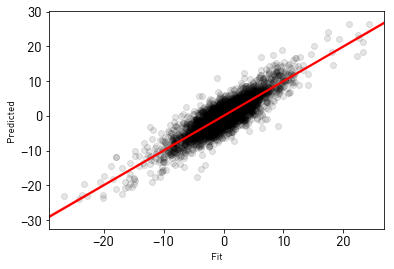

In [103]:
sim_predict = ytil[-500:,:,None].mean(axis=0).flatten()
sns.regplot(sim_predict, Y.flatten(), 
            scatter_kws=dict(color='k', marker='.', alpha=.1),
            line_kws=dict(color='r'))
plt.xlabel('Fit')
plt.ylabel('Predicted')
print('R-squared: {}'.format(metrics.r2_score(Y,sim_predict)))

Let's look at how extreme they are, though. To do this, I'll compute the 5% exterior values, and try to find borders that have observed values larger/smaller than the extreme 5% of simulations for that border value. 

In [104]:
pctiles = np.percentile(ytil[-500:,:,None], q=(2.5, 97.25), axis=0).squeeze()
yext = ~((Y > pctiles[0,:,None]) * (Y < pctiles[1,:,None]))
ylow = -1 * (Y < pctiles[0,:,None]).astype(int)
yup = (Y > pctiles[1,:,None]).astype(int)
ycat = ylow + yup

So, those extremal values are now in the binary indicator vector, `yext`. I'll plot them so that "extreme" values are red:

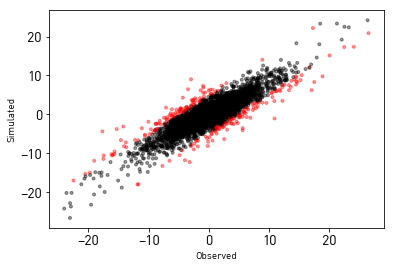

In [105]:
plt.scatter(Y, ytil[-500:,:,None].mean(axis=0), 
         color=[('k','r')[x] 
                for x in yext.astype(int).flatten()],
           marker = '.', 
           alpha=.4)
plt.xlabel('Observed')
plt.ylabel('Simulated')

It looks like the black & red sets aren't able to be separated neatly into two lines. In addition, it's important to note that these are cases where the $Y$ is in the exterior 95% of simulations **for that value**. So, it's not just extreme simulated values that get picked up here, it's values where the observed value is quite unlikely to be simulated. 

To investigate whether these are actually separable, let's zoom a little in on one half of the distribution:

In [106]:
Y > pctiles.squeeze()[0,:,None] #these are values whose observed
                      # Y values are bigger than the  
                      # smallest 2.5% of simulations

array([[ True],
       [ True],
       [ True],
       ..., 
       [ True],
       [ True],
       [ True]], dtype=bool)

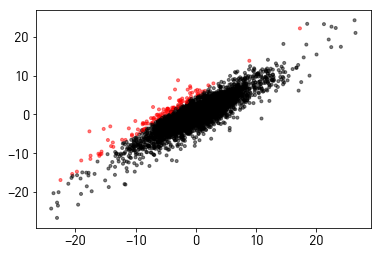

In [107]:
plt.scatter(Y, ytil.mean(axis=0), 
         color=[('k','r')[x] 
                for x in (Y < pctiles[0,:,None])\
                         .astype(int).flatten()],
           marker = '.', 
           alpha=.5)

In [109]:
from sklearn import svm

In [110]:
lclass = svm.SVC(kernel='linear')

In [111]:
Ystack = np.hstack((Y, ytil[-500:,:].mean(axis=0)[:,None]))
lclass.fit(Ystack, (Y < pctiles[0,:,None]).astype(int).flatten())

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [112]:
lclass.coef_

array([[-3.16506505,  3.18425911]])

Below, I'll plot the best fit separating line between the two groups and highlight the supporting points that were found:

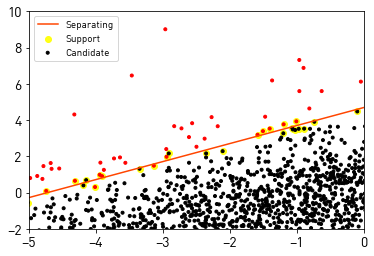

In [116]:
support = np.arange(-40,40)
m = -lclass.coef_[0,0]/lclass.coef_[0,1]
b = lclass.intercept_[0]/lclass.coef_[0,1]
plt.plot(support, m*support - b, color='orangered', label='Separating')
plt.scatter(*lclass.support_vectors_.T,
            color='yellow', marker='o', label='Support', alpha=.9)
plt.scatter(Y, ytil[-500:,:].mean(axis=0), 
         color=[('k','r')[x] 
                for x in (Y < pctiles[0,:,None])\
                         .astype(int).flatten()],
           marker = '.', 
           alpha=1, label='Candidate')
plt.axis([-5,0,-2,10])
plt.legend(fontsize=10)

In general, this is a really good separation, since it gets 99% correct:

In [117]:
lclass.score(Ystack, (Y < pctiles[0,:,None]).astype(int).flatten())

0.99628988374969085

Let's look at those boundaries spatially, if we can:

In [118]:
alist = filter_adjlist(adjacencylist_from_W(W))
alist['Y'] = Y
alist['Ytil'] = ytil[-500:,:].mean(axis=0)[:,None]
alist['Yhat'] = yhat
alist['Ytil_ext'] = yext
alist['Ytil_directed'] = ycat

In [130]:
df['centroid'] = df.geometry.apply(lambda x: x.centroid)

In [131]:
df.centroid.isnull().any()

False

In [132]:
pd.merge(df[['centroid']], alist, how='inner', left_index=True,
         right_on='focal')['centroid'].shape

(4043,)

In [133]:
alist['focal_XY'] = pd.merge(df[['centroid']], alist, how='right',
                             left_index=True, 
                             right_on='focal',
                             )['centroid']

In [134]:
alist['neighbor_XY'] = pd.merge(df[['centroid']], alist, 
                                how='right',
                                left_index=True, 
                                right_on='neighbor')['centroid']

In [135]:
from pysal.contrib.viz.mapping import geoplot

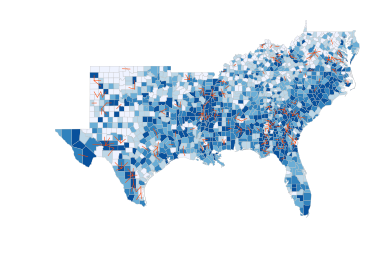

In [136]:
%matplotlib inline
f,ax = plt.subplots(1,1)
geoplot(df, ax=ax, col='HR90', palette='blues')
for ix, row in alist.iterrows():
        points = zip(*row[['focal_XY', 'neighbor_XY']].values)
        c = ['w','orangered'][int(row.Ytil_ext)]
        lw = [0,.5][int(row.Ytil_ext)]
        ax.plot(*points, color=c, linewidth=lw)
plt.savefig('womble_map.png', dpi=800)
plt.show()